# Google Landmark 2019

References:
4th place solution last year
https://www.kaggle.com/c/landmark-recognition-challenge/discussion/57896#latest-418704

Compressed and resized training and test images
https://www.kaggle.com/c/landmark-recognition-2019/discussion/91770#latest-532165

https://www.kaggle.com/c/landmark-recognition-2019/discussion/90346#latest-532193

EDA and loading data
https://www.kaggle.com/mayukh18/dataset-exploration-and-simple-on-the-fly-training



Plan

1. bring in training images that have >K examples for each class.  K=10
2. Train resnet34 on this and see xval score (basic classification)
3. Understand how to measure the metric being optimized in the contest
4. develop a heuristic/trained approach for submitting results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import torch


In [3]:
from smtplib import SMTP_SSL as SMTP
from email.mime.text import MIMEText
def send_txt(subject, body, toaddr="6519834115@tmomail.net"):
    fromaddr = "thebignotifier@gmail.com"
    msg = MIMEText(body, 'plain')
    msg['To'] = toaddr
    msg['Subject'] = subject

    server = SMTP('smtp.gmail.com')
    server.login(fromaddr, "eatbzltjueqfdopg")
    server.sendmail(fromaddr, toaddr, msg.as_string())
    server.quit()

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 100
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [5]:
path=Path("/media/SSD/data_google_landmark_recog_2019")
path.ls()

[PosixPath('/media/SSD/data_google_landmark_recog_2019/train.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/recognition_sample_submission.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256.tar'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/data_import.sh'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission1.1.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split1.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split2.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test-256'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test-256.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission1.csv')]

In [6]:
path_img = path / 'train-256'
path_img

PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256')

## Looking at the data

In [7]:
train = pd.read_csv(path / "train.csv")
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))


                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474  
(4132914, 3)
Number of classes 203094


In [8]:
files = os.listdir(path_img)

In [9]:
#get all the files in the image directory and drop the ''.jpg' of the filename to get the 'id' of the image
def clean_string (x):
    return x[:-4]

#lst = set(map(clean_string,os.listdir(path_img)))
lst = set([clean_string(x) for x in files if '.jpg' in x])

In [10]:
# select image ids that have image files
lst3 = [value[0] for value in zip(train.index, train['id']) if value[1] in lst]
train2=train.loc[lst3]

In [11]:
K=100
counts = dict(Counter(train2['landmark_id']))
landmarks_dict = {x:[] for x in train2.landmark_id.unique() if (counts[x] >= K)}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

Total number of valid classes: 6513


In [12]:
new_train = train2[train2['landmark_id'].isin(landmarks_dict)].copy()
print(new_train.head())
print(new_train.shape)
print("Number of classes {}".format(len(new_train.landmark_id.unique())))

                  id                                                url  \
1   202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
4   4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   
6   6f31b874d1a4d489  https://upload.wikimedia.org/wikipedia/commons...   
9   8df019949b8db328  https://upload.wikimedia.org/wikipedia/commons...   
11  ccf070a2da242d56  https://upload.wikimedia.org/wikipedia/commons...   

    landmark_id  
1        104169  
4          2474  
6          6888  
9         81049  
11       138982  
(1263760, 3)
Number of classes 6513


In [14]:
del train2,train, lst, files, lst3, counts, landmarks_dict

In [15]:
learn=None
gc.collect()
torch.cuda.empty_cache()

In [16]:
#data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg', ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg', ds_tfms=get_transforms(), size=224, bs=bs, num_workers=5).normalize(imagenet_stats)


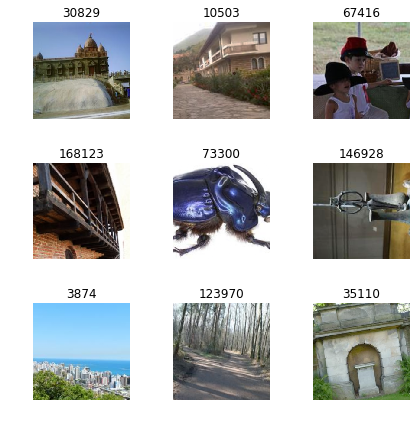

In [17]:
data.show_batch(rows=3, figsize=(6,6))

## Training: resnet50

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [20]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate).to_fp16()
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [17]:
learn.freeze()
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,error_rate,time
0,6.595542,6.042687,0.854434,54:52
1,6.229784,5.470376,0.809382,54:49
2,6.147468,5.294288,0.790878,54:59
3,6.055570,5.178288,0.779214,54:54
4,5.968627,5.069932,0.765050,55:05
5,5.923729,5.006555,0.756690,55:03
6,5.792211,4.912162,0.745486,55:06
7,5.757032,4.861281,0.739618,55:07
8,5.726953,4.802961,0.730859,55:13
9,5.640211,4.735708,0.723567,55:16


In [18]:
learn.save('res50-stage-1')

In [19]:
send_txt("!!","training stage 1 complete")

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

RuntimeError: expected scalar type Half but found Float

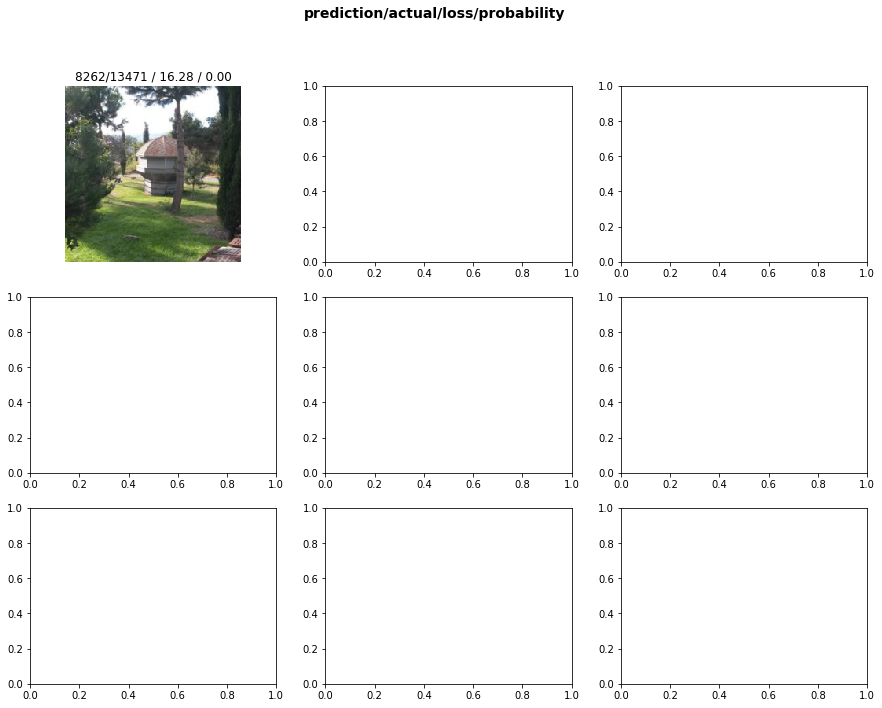

In [36]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)

KeyboardInterrupt: 

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [23]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,5.714209,4.955976,0.740516,1:07:18


In [21]:
learn.load('res50-stage-1');

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.00E-05


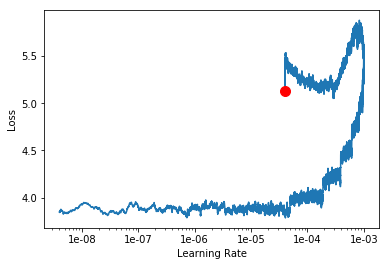

In [25]:
learn.recorder.plot(suggestion=True)

In [25]:
send_txt("!!","learning rate graph complete")

In [22]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,5.207144,4.508842,0.684841,1:08:51
1,5.775583,4.693174,0.732469,1:06:38
2,5.542168,4.529638,0.710871,1:06:43
3,5.132148,4.297796,0.679967,1:06:46
4,4.866878,4.085572,0.652913,1:06:56
5,4.654157,3.896342,0.626682,1:06:56
6,4.376338,3.751728,0.598698,1:06:56
7,4.083554,3.658507,0.575022,1:07:02
8,3.973648,3.625482,0.555833,1:07:14
9,3.853833,3.595880,0.549895,1:07:02


In [23]:
learn.save('res50-stage-2')

In [24]:
send_txt("!!","stage2 complete")

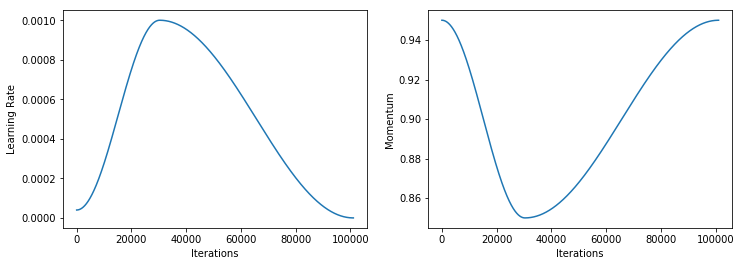

In [26]:
learn.recorder.plot_lr(show_moms=True)

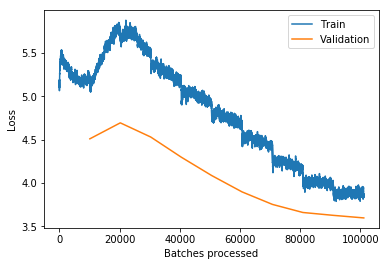

In [27]:
learn.recorder.plot_losses()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


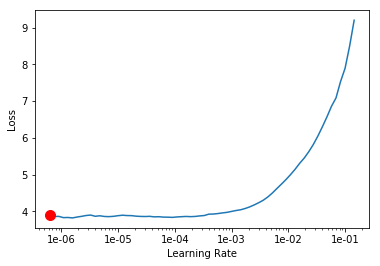

In [29]:
learn.recorder.plot(suggestion=True)

In [30]:
send_txt("!!","learning rate graph complete")

In [31]:
learn.load('res50-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (1011008 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
6888,81049,187670,189446,117635
Path: /media/SSD/data_google_landmark_recog_2019/train-256;

Valid: LabelList (252752 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
122658,4093,126465,180970,34807
Path: /media/SSD/data_google_landmark_recog_2019/train-256;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [32]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(2e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,4.163389,3.661663,0.590357,1:07:02
1,5.148728,4.142591,0.659560,1:06:57
2,4.998232,4.140656,0.657407,1:06:54
3,4.700384,3.972912,0.635295,1:07:02
4,4.493228,3.855052,0.617214,1:07:06
5,4.291562,3.673822,0.594001,1:07:03
6,4.035313,3.488971,0.566417,1:06:57
7,3.737341,3.376861,0.540166,1:07:01
8,3.571572,3.339785,0.524320,1:06:54
9,3.455509,3.328915,0.517214,1:07:06


In [33]:
learn.save('res50-stage-3')

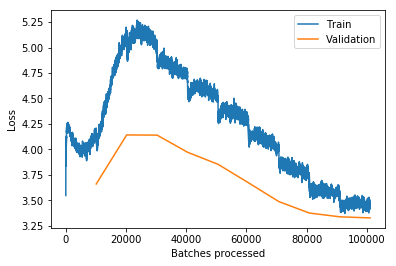

In [34]:
learn.recorder.plot_losses()

Min numerical gradient: 4.87E-04


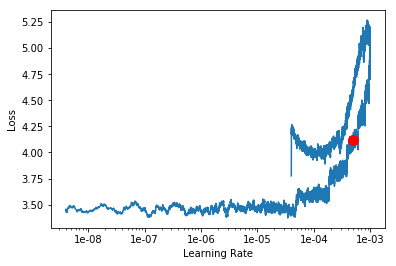

In [35]:
learn.recorder.plot(suggestion=True)

In [36]:
send_txt("!!","stage3 complete")

In [37]:
learn.fit(7, lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,3.868074,3.560623,0.562100,1:07:11
1,3.845798,3.544554,0.557400,1:07:06
2,3.799476,3.532396,0.557657,1:06:51
3,3.772818,3.499502,0.555038,1:07:00
4,3.732523,3.447838,0.547651,1:06:56
5,3.657051,3.439439,0.546931,1:06:55
6,3.657390,3.385894,0.542330,1:07:03


In [38]:
learn.save('res50-stage-4')

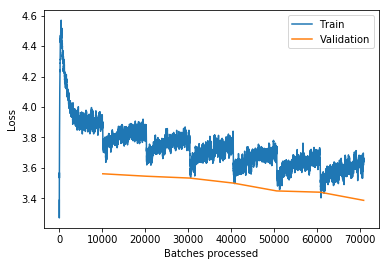

In [39]:
learn.recorder.plot_losses()

Min numerical gradient: 1.00E-04


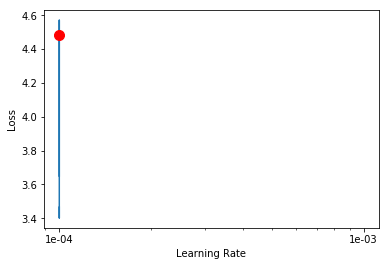

In [40]:
learn.recorder.plot(suggestion=True)

In [41]:
send_txt("!!","stage4 complete")

In [51]:
learn.fit_one_cycle(45, max_lr=slice(2e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,3.258556,3.260869,0.513614,1:07:06
1,3.286173,3.219128,0.515145,1:07:07
2,3.370124,3.229457,0.522817,1:07:08
3,3.538862,3.286839,0.534164,1:07:11
4,3.788628,3.414400,0.544510,1:07:07
5,3.926777,3.503811,0.550896,1:07:16
6,4.051225,3.561135,0.557103,1:07:16
7,4.044183,3.581446,0.561396,1:07:16
8,4.051017,3.600374,0.567141,1:07:16
9,4.007923,3.608692,0.570306,1:07:16


In [52]:
learn.save('res50-stage-5')

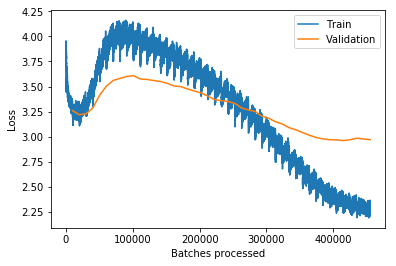

In [53]:
learn.recorder.plot_losses()

Min numerical gradient: 4.00E-05


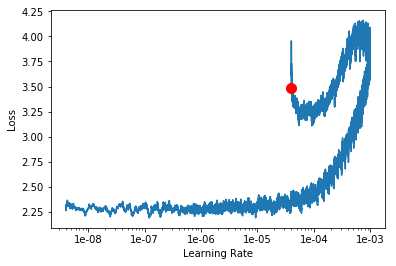

In [54]:
learn.recorder.plot(suggestion=True)

In [55]:
send_txt("!!","stage5 complete")

In [86]:
learn.load('res50-stage-5')

FileNotFoundError: [Errno 2] No such file or directory: '/media/SSD/data_google_landmark_recog_2019/train-256/res50/models/res50-stage-5.pth'

# Predict test set

In [87]:
#export model and other contains everything we need to deploy our model 
#(the model, the weights but also some metadata like the classes or the transforms/normalization used).
learn.export("export.pkl")

#to load it
#learn = load_learner(path)


In [57]:
# path to test set
path_test = path / 'test-256/test'
path_test

PosixPath('/media/SSD/data_google_landmark_recog_2019/test-256/test')

In [58]:
# load submission
submission = pd.read_csv(path / 'recognition_sample_submission.csv', index_col='id')


In [65]:
# predict test set
#from fastprogress import master_bar, progress_bar

for fn in progress_bar(submission.index):
    try:
        img = open_image(path_test / (fn + '.jpg'))
    except:
        #print("file not found:"+ fn + '.jpg')
        submission.loc[fn]=""
    else:
        pred_class,pred_idx,outputs = learn.predict(img)
        #print(pred_class, pred_idx,outputs[pred_idx])
        submission.loc[fn]=str(pred_class)+ " "+ str(outputs[pred_idx].item())
submission[0:20]
    

AttributeError: 'Image' object has no attribute 'normalize'

In [60]:
submission.to_csv(path / 'submission3.csv',index=True)

In [61]:
send_txt("!!","test submission 3 complete")

https://www.kaggle.com/c/landmark-recognition-2019/discussion/89903#latest-530343

Hello everyone,
in train data Landmark with Id = 138982 has 10247 images. I looked at some of them and found that they are from rather different places.
So i think that images with this Landmark_Id are not associated with any real landmark. 

In [62]:
#blank out the results to indicate no mandmarl for this id
submission.loc[submission['landmarks'].str.contains('138982 '), 'landmarks'] = ""

In [63]:
submission.to_csv(path / 'submission3.1.csv',index=True)

In [64]:
send_txt("!!","test submission 3.1 complete")